# Multilingual Synthetic Fake News Generation

This notebook generates synthetic fake news articles using GPT-4.1 to address class imbalance.

**Objective**: Generate ~100 synthetic fake articles per language (5 languages) to fix 20% imbalance

**Languages**: Vietnamese, English, Hindi, Swahili, Indonesian

**Approach**: Zero-shot generation using enhanced prompts with:
- Stylistic features (16 language-agnostic characteristics)
- N-grams (common bigrams and trigrams)
- Topics (LDA-extracted themes)
- Concrete examples and guidelines

## 1. Setup and Imports

In [14]:
import os
import json
import time
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

# OpenAI API
from openai import OpenAI
from dotenv import load_dotenv

# Feature extraction
import re
import string
from collections import Counter

# Load environment variables
load_dotenv()
api_key = os.getenv('OPENAI_API_KEY')

if not api_key:
    raise ValueError("OpenAI API key not found in .env file")

# Initialize OpenAI client
client = OpenAI(api_key=api_key)

print("✅ Setup complete")
print(f"API key loaded")

✅ Setup complete
API key loaded


## 2. Load Analysis Results

In [15]:
# Define paths
data_dir = Path('/home/mateja/Documents/IJS/current/Fairer_Models/data/processed')
prompts_dir = data_dir / 'generation_prompts'

# Languages to generate for (full names)
languages = ['vietnamese', 'english', 'hindi', 'swahili', 'indonesian']

# Map to prompt file names (which use language codes for some)
language_file_map = {
    'vietnamese': 'vi',
    'english': 'english',
    'hindi': 'hindi',
    'swahili': 'sw',
    'indonesian': 'indonesian'
}

# Load generation prompts
prompts = {}
for lang in languages:
    file_lang = language_file_map[lang]
    prompt_file = prompts_dir / f'{file_lang}_generation_prompt.txt'
    if prompt_file.exists():
        with open(prompt_file, 'r', encoding='utf-8') as f:
            prompts[lang] = f.read()
        print(f"✅ Loaded {lang} prompt ({len(prompts[lang])} chars)")
    else:
        print(f"❌ Missing prompt for {lang} (tried: {file_lang}_generation_prompt.txt)")

# Load feature analysis results
feature_stats_file = data_dir / 'feature_statistical_analysis.csv'
if feature_stats_file.exists():
    feature_stats = pd.read_csv(feature_stats_file)
    print(f"\n✅ Loaded feature statistics: {len(feature_stats)} rows")
    print(feature_stats.head())
else:
    print(f"❌ Feature statistics not found at {feature_stats_file}")
    feature_stats = None

# Load master summary
summary_file = data_dir / 'master_feature_analysis_summary.json'
if summary_file.exists():
    with open(summary_file, 'r', encoding='utf-8') as f:
        master_summary = json.load(f)
    # Languages are nested in experiment_info
    num_languages = len(master_summary.get('experiment_info', {}).get('languages', []))
    print(f"\n✅ Loaded master summary for {num_languages} languages")
else:
    print(f"❌ Master summary not found at {summary_file}")
    master_summary = None

✅ Loaded vietnamese prompt (3086 chars)
✅ Loaded english prompt (2891 chars)
✅ Loaded hindi prompt (2817 chars)
✅ Loaded swahili prompt (2880 chars)
✅ Loaded indonesian prompt (3080 chars)

✅ Loaded feature statistics: 80 rows
  language              feature   fake_mean  legit_mean  difference  \
0       vi           char_count  244.489510  233.144654   11.344856   
1       vi           word_count   53.363636   50.100629    3.263007   
2       vi      avg_word_length    3.616519    3.914598   -0.298079   
3       vi       sentence_count    2.062937    1.930818    0.132119   
4       vi  avg_sentence_length   28.934966   27.075673    1.859293   

   diff_percentage   p_value  significant  
0         4.866016  0.490895        False  
1         6.512907  0.361349        False  
2        -7.614539  0.004699         True  
3         6.842669  0.371871        False  
4         6.867025  0.093952        False  

✅ Loaded master summary for 5 languages


### 2.1 Verify Prompts Loaded Correctly

In [16]:
# Verify all prompts loaded and show sample
print("="*80)
print("PROMPT VERIFICATION")
print("="*80)

all_loaded = True
for lang in languages:
    if lang in prompts:
        prompt_preview = prompts[lang][:200] + "..." if len(prompts[lang]) > 200 else prompts[lang]
        
        # Check key sections are present
        sections_present = {
            'Stylistic Characteristics': '## 1. Key Stylistic' in prompts[lang],
            'Generation Guidelines': '## 2. Concrete' in prompts[lang],
            'N-grams': '## 3. Common Phrases' in prompts[lang],
            'Topics': '## 4. Main Topics' in prompts[lang],
            'Examples': '## 5. Example' in prompts[lang],
            'Task': '## 6. Your Task' in prompts[lang]
        }
        
        missing = [k for k, v in sections_present.items() if not v]
        
        print(f"\n✅ {lang.upper()}:")
        print(f"   Length: {len(prompts[lang])} chars")
        print(f"   Sections: {sum(sections_present.values())}/6 present")
        if missing:
            print(f"   ⚠️  Missing: {', '.join(missing)}")
        print(f"   Preview: {prompt_preview}")
    else:
        print(f"\n❌ {lang.upper()}: NOT LOADED")
        all_loaded = False

print("\n" + "="*80)
if all_loaded and len(prompts) == len(languages):
    print("✅ ALL PROMPTS SUCCESSFULLY LOADED AND VERIFIED")
    print(f"   Total: {len(prompts)} prompts ready for generation")
else:
    print(f"⚠️  WARNING: Only {len(prompts)}/{len(languages)} prompts loaded")
    missing_langs = [l for l in languages if l not in prompts]
    if missing_langs:
        print(f"   Missing: {', '.join(missing_langs)}")
print("="*80)

PROMPT VERIFICATION

✅ VIETNAMESE:
   Length: 3086 chars
   Sections: 6/6 present
   Preview: # Fake News Generation Task - Vietnamese Celebrity News
Generate fake celebrity news articles in Vietnamese that match the stylistic patterns below.

## 1. Key Stylistic Characteristics
Fake news in V...

✅ ENGLISH:
   Length: 2891 chars
   Sections: 6/6 present
   Preview: # Fake News Generation Task - English Celebrity News
Generate fake celebrity news articles in English that match the stylistic patterns below.

## 1. Key Stylistic Characteristics
Fake news in English...

✅ HINDI:
   Length: 2817 chars
   Sections: 6/6 present
   Preview: # Fake News Generation Task - Hindi Celebrity News
Generate fake celebrity news articles in Hindi that match the stylistic patterns below.

## 1. Key Stylistic Characteristics
Fake news in Hindi diffe...

✅ SWAHILI:
   Length: 2880 chars
   Sections: 6/6 present
   Preview: # Fake News Generation Task - Swahili Celebrity News
Generate fake celebrity news a

## 3. Feature Extraction Function

In [17]:
def extract_comprehensive_features(text: str) -> Dict[str, float]:
    """
    Extract 16 language-agnostic stylistic features from text.
    Same function used in feature analysis to ensure consistency.
    """
    if not isinstance(text, str) or len(text) == 0:
        return {f: 0.0 for f in [
            'char_count', 'word_count', 'sentence_count', 'avg_word_length',
            'avg_sentence_length', 'punctuation_ratio', 'uppercase_ratio',
            'digit_ratio', 'special_char_ratio', 'unique_word_ratio',
            'short_word_ratio', 'long_word_ratio', 'lexical_diversity',
            'exclamation_ratio', 'question_ratio', 'quote_ratio'
        ]}
    
    # Basic counts
    char_count = len(text)
    words = text.split()
    word_count = len(words)
    
    # Sentence segmentation (basic - split on .!?)
    sentences = [s.strip() for s in re.split(r'[.!?]+', text) if s.strip()]
    sentence_count = len(sentences)
    
    # Word-level features
    avg_word_length = np.mean([len(w) for w in words]) if words else 0
    avg_sentence_length = word_count / sentence_count if sentence_count > 0 else 0
    
    # Character type ratios
    punctuation_ratio = sum(1 for c in text if c in string.punctuation) / char_count
    uppercase_ratio = sum(1 for c in text if c.isupper()) / char_count
    digit_ratio = sum(1 for c in text if c.isdigit()) / char_count
    special_char_ratio = sum(1 for c in text if not c.isalnum() and not c.isspace()) / char_count
    
    # Vocabulary features
    unique_words = set(words)
    unique_word_ratio = len(unique_words) / word_count if word_count > 0 else 0
    short_word_ratio = sum(1 for w in words if len(w) <= 3) / word_count if word_count > 0 else 0
    long_word_ratio = sum(1 for w in words if len(w) >= 10) / word_count if word_count > 0 else 0
    lexical_diversity = len(unique_words) / word_count if word_count > 0 else 0
    
    # Specific punctuation ratios
    exclamation_ratio = text.count('!') / char_count
    question_ratio = text.count('?') / char_count
    quote_ratio = (text.count('"') + text.count("'")) / char_count
    
    return {
        'char_count': char_count,
        'word_count': word_count,
        'sentence_count': sentence_count,
        'avg_word_length': avg_word_length,
        'avg_sentence_length': avg_sentence_length,
        'punctuation_ratio': punctuation_ratio,
        'uppercase_ratio': uppercase_ratio,
        'digit_ratio': digit_ratio,
        'special_char_ratio': special_char_ratio,
        'unique_word_ratio': unique_word_ratio,
        'short_word_ratio': short_word_ratio,
        'long_word_ratio': long_word_ratio,
        'lexical_diversity': lexical_diversity,
        'exclamation_ratio': exclamation_ratio,
        'question_ratio': question_ratio,
        'quote_ratio': quote_ratio
    }

print("✅ Feature extraction function defined")

✅ Feature extraction function defined


## 4. Generation Configuration

In [18]:
# Generation parameters
GENERATION_CONFIG = {
    'model': 'gpt-4-turbo-preview',  # GPT-4.1
    'temperature': 0.7,
    'max_tokens': 2000,
    'articles_per_language': 100,
    'sleep_between_calls': 0.5,  # Rate limiting
    'max_retries': 3
}

# Topics for generation (political/celebrity domain)
TOPICS = [
    "political scandal involving public figure",
    "celebrity controversy and public backlash",
    "government policy implementation failure",
    "corruption allegations against official",
    "electoral fraud claims and investigations",
    "celebrity relationship drama and rumors",
    "legislative debate on controversial issue",
    "public figure's controversial statement",
    "celebrity endorsement controversy",
    "political party internal conflict",
    "celebrity legal troubles and court case",
    "regulatory decision sparking protests",
    "celebrity behavior causing outrage",
    "campaign finance irregularities exposed",
    "political figure's past actions revealed"
]

print(f"✅ Configuration set:")
print(f"   Model: {GENERATION_CONFIG['model']}")
print(f"   Target: {GENERATION_CONFIG['articles_per_language']} articles per language")
print(f"   Total: {GENERATION_CONFIG['articles_per_language'] * len(languages)} articles")
print(f"   Topics: {len(TOPICS)} available")

✅ Configuration set:
   Model: gpt-4-turbo-preview
   Target: 100 articles per language
   Total: 500 articles
   Topics: 15 available


## 5. Zero-Shot Generation Function

In [19]:
def generate_article(language: str, topic: str, prompt_template: str) -> Dict:
    """
    Generate a single synthetic fake news article using zero-shot approach.
    
    Args:
        language: Target language for generation
        topic: Topic/theme for the article
        prompt_template: Enhanced prompt with features, n-grams, topics
    
    Returns:
        Dictionary with generated article and metadata
    """
    max_retries = GENERATION_CONFIG['max_retries']
    
    for attempt in range(max_retries):
        try:
            # Format prompt with topic
            full_prompt = prompt_template.replace('{topic}', topic)
            
            # Call GPT-4.1
            response = client.chat.completions.create(
                model=GENERATION_CONFIG['model'],
                messages=[
                    {
                        "role": "system",
                        "content": f"You are creating synthetic fake news articles in {language} for research purposes. Follow the provided stylistic guidelines exactly to match real fake news patterns."
                    },
                    {
                        "role": "user",
                        "content": full_prompt
                    }
                ],
                max_tokens=GENERATION_CONFIG['max_tokens'],
                temperature=GENERATION_CONFIG['temperature']
            )
            
            # Extract generated text
            article_text = response.choices[0].message.content.strip()
            
            # Extract features for validation
            features = extract_comprehensive_features(article_text)
            
            return {
                'language': language,
                'topic': topic,
                'article': article_text,
                'features': features,
                'model': GENERATION_CONFIG['model'],
                'temperature': GENERATION_CONFIG['temperature'],
                'timestamp': datetime.now().isoformat(),
                'attempt': attempt + 1,
                'success': True
            }
            
        except Exception as e:
            print(f"   ⚠️ Attempt {attempt + 1}/{max_retries} failed for {language}: {str(e)}")
            if attempt < max_retries - 1:
                time.sleep(2 ** attempt)  # Exponential backoff
            else:
                return {
                    'language': language,
                    'topic': topic,
                    'article': None,
                    'error': str(e),
                    'timestamp': datetime.now().isoformat(),
                    'success': False
                }
    
    return None

print("✅ Generation function defined")

✅ Generation function defined


## 6. Feature Validation Function

In [20]:
def validate_article_features(features: Dict[str, float], language: str, 
                             feature_stats: pd.DataFrame) -> Dict:
    """
    Validate that generated article features match target fake news characteristics.
    
    Args:
        features: Extracted features from generated article
        language: Target language (full name: 'vietnamese', 'english', etc.)
        feature_stats: Statistical analysis dataframe with target ranges
    
    Returns:
        Dictionary with validation results
    """
    if feature_stats is None:
        return {'validation': 'skipped', 'reason': 'no_stats_available'}
    
    # Map full language names to feature_stats language names
    lang_map = {
        'vietnamese': 'vi',
        'english': 'English',
        'hindi': 'Hindi',
        'swahili': 'sw',
        'indonesian': 'Indonesian'
    }
    
    stats_lang = lang_map.get(language, language)
    
    # Filter for this language (fake_mean column already has fake news stats)
    lang_stats = feature_stats[feature_stats['language'] == stats_lang]
    
    if len(lang_stats) == 0:
        return {'validation': 'skipped', 'reason': 'no_language_stats'}
    
    validation_results = {
        'features_checked': 0,
        'features_in_range': 0,
        'compliance_rate': 0.0,
        'out_of_range': []
    }
    
    # Check each feature against expected range (fake_mean ± fake_std)
    # Note: We'll use difference/2 as approximation for std since CSV doesn't have it
    for _, row in lang_stats.iterrows():
        feature_name = row['feature']
        if feature_name not in features:
            continue
        
        mean = row['fake_mean']
        # Approximate std from difference (rough estimate for validation)
        std = abs(row['difference']) / 2
        value = features[feature_name]
        
        # Define acceptable range as mean ± 2*std (95% confidence)
        lower_bound = mean - 2 * std
        upper_bound = mean + 2 * std
        
        validation_results['features_checked'] += 1
        
        if lower_bound <= value <= upper_bound:
            validation_results['features_in_range'] += 1
        else:
            validation_results['out_of_range'].append({
                'feature': feature_name,
                'value': value,
                'expected_range': [lower_bound, upper_bound],
                'deviation': min(abs(value - lower_bound), abs(value - upper_bound))
            })
    
    if validation_results['features_checked'] > 0:
        validation_results['compliance_rate'] = (
            validation_results['features_in_range'] / 
            validation_results['features_checked']
        )
    
    return validation_results

print("✅ Validation function defined")

✅ Validation function defined


## 7. Main Generation Loop

In [21]:
def generate_articles_for_all_languages():
    """
    Generate synthetic fake news articles for all languages.
    """
    all_results = []
    summary_stats = {
        'start_time': datetime.now().isoformat(),
        'languages': {},
        'total_generated': 0,
        'total_failed': 0
    }
    
    print("\n" + "="*80)
    print("🚀 Starting Multilingual Synthetic Article Generation")
    print("="*80 + "\n")
    
    for lang in languages:
        print(f"\n{'='*80}")
        print(f"📝 Generating {GENERATION_CONFIG['articles_per_language']} articles for: {lang.upper()}")
        print(f"{'='*80}\n")
        
        if lang not in prompts:
            print(f"❌ No prompt available for {lang}, skipping...")
            continue
        
        lang_results = []
        lang_stats = {
            'generated': 0,
            'failed': 0,
            'avg_compliance': 0.0,
            'avg_char_count': 0.0,
            'avg_word_count': 0.0
        }
        
        for i in range(GENERATION_CONFIG['articles_per_language']):
            # Select random topic
            topic = np.random.choice(TOPICS)
            
            # Generate article
            result = generate_article(lang, topic, prompts[lang])
            
            if result and result['success']:
                # Validate features
                validation = validate_article_features(
                    result['features'], lang, feature_stats
                )
                result['validation'] = validation
                
                lang_results.append(result)
                lang_stats['generated'] += 1
                
                # Progress update
                if (i + 1) % 10 == 0:
                    compliance = validation.get('compliance_rate', 0)
                    char_count = result['features']['char_count']
                    print(f"   ✅ {i + 1}/{GENERATION_CONFIG['articles_per_language']} | "
                          f"Compliance: {compliance:.1%} | Chars: {char_count}")
            else:
                lang_stats['failed'] += 1
                print(f"   ❌ Failed: {i + 1}")
            
            # Rate limiting
            time.sleep(GENERATION_CONFIG['sleep_between_calls'])
        
        # Calculate language statistics
        if lang_results:
            compliances = [r['validation'].get('compliance_rate', 0) 
                          for r in lang_results if 'validation' in r]
            char_counts = [r['features']['char_count'] for r in lang_results]
            word_counts = [r['features']['word_count'] for r in lang_results]
            
            lang_stats['avg_compliance'] = np.mean(compliances) if compliances else 0
            lang_stats['avg_char_count'] = np.mean(char_counts)
            lang_stats['avg_word_count'] = np.mean(word_counts)
        
        summary_stats['languages'][lang] = lang_stats
        summary_stats['total_generated'] += lang_stats['generated']
        summary_stats['total_failed'] += lang_stats['failed']
        
        all_results.extend(lang_results)
        
        print(f"\n✅ {lang.upper()} Complete:")
        print(f"   Generated: {lang_stats['generated']}")
        print(f"   Failed: {lang_stats['failed']}")
        print(f"   Avg Compliance: {lang_stats['avg_compliance']:.1%}")
        print(f"   Avg Length: {lang_stats['avg_char_count']:.0f} chars, "
              f"{lang_stats['avg_word_count']:.0f} words")
    
    summary_stats['end_time'] = datetime.now().isoformat()
    
    print("\n" + "="*80)
    print("✅ Generation Complete!")
    print("="*80)
    print(f"Total Generated: {summary_stats['total_generated']}")
    print(f"Total Failed: {summary_stats['total_failed']}")
    print(f"Success Rate: {summary_stats['total_generated']/(summary_stats['total_generated']+summary_stats['total_failed']):.1%}")
    
    return all_results, summary_stats

print("✅ Main generation loop defined")

✅ Main generation loop defined


## 8. Run Generation

In [22]:
# Execute generation
generated_articles, generation_summary = generate_articles_for_all_languages()


🚀 Starting Multilingual Synthetic Article Generation


📝 Generating 100 articles for: VIETNAMESE

   ✅ 10/100 | Compliance: 38.5% | Chars: 286
   ✅ 10/100 | Compliance: 38.5% | Chars: 286
   ✅ 20/100 | Compliance: 46.2% | Chars: 312
   ✅ 20/100 | Compliance: 46.2% | Chars: 312
   ✅ 30/100 | Compliance: 38.5% | Chars: 261
   ✅ 30/100 | Compliance: 38.5% | Chars: 261
   ✅ 40/100 | Compliance: 46.2% | Chars: 284
   ✅ 40/100 | Compliance: 46.2% | Chars: 284
   ✅ 50/100 | Compliance: 30.8% | Chars: 322
   ✅ 50/100 | Compliance: 30.8% | Chars: 322
   ✅ 60/100 | Compliance: 76.9% | Chars: 248
   ✅ 60/100 | Compliance: 76.9% | Chars: 248
   ✅ 70/100 | Compliance: 38.5% | Chars: 382
   ✅ 70/100 | Compliance: 38.5% | Chars: 382
   ✅ 80/100 | Compliance: 30.8% | Chars: 317
   ✅ 80/100 | Compliance: 30.8% | Chars: 317
   ✅ 90/100 | Compliance: 46.2% | Chars: 274
   ✅ 90/100 | Compliance: 46.2% | Chars: 274
   ✅ 100/100 | Compliance: 46.2% | Chars: 338
   ✅ 100/100 | Compliance: 46.2% | Chars: 338

## 9. Export Results

In [28]:
# Create export directory
export_dir = Path('/home/mateja/Documents/IJS/current/Fairer_Models/data/synthetic')
export_dir.mkdir(exist_ok=True)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Convert to DataFrame
results_df = pd.DataFrame([
    {
        'language': r['language'],
        'topic': r['topic'],
        'article': r['article'],
        'model': r['model'],
        'temperature': r['temperature'],
        'timestamp': r['timestamp'],
        'compliance_rate': r['validation'].get('compliance_rate', None),
        'features_in_range': r['validation'].get('features_in_range', None),
        'features_checked': r['validation'].get('features_checked', None),
        **{f'feature_{k}': v for k, v in r['features'].items()}
    }
    for r in generated_articles if r['success']
])

# Export main results
results_file = export_dir / f'synthetic_articles_{timestamp}.csv'
results_df.to_csv(results_file, index=False)
print(f"✅ Exported {len(results_df)} articles to: {results_file}")

# Export summary statistics
summary_file = export_dir / f'generation_summary_{timestamp}.json'
with open(summary_file, 'w') as f:
    json.dump(generation_summary, f, indent=2)
print(f"✅ Exported summary to: {summary_file}")

# Export by language for easy loading
for lang in languages:
    lang_df = results_df[results_df['language'] == lang]
    if len(lang_df) > 0:
        lang_file = export_dir / f'synthetic_articles_{lang}_{timestamp}.csv'
        lang_df.to_csv(lang_file, index=False)
        print(f"✅ Exported {len(lang_df)} {lang} articles to: {lang_file}")

print("\n✅ All exports complete!")

✅ Exported 500 articles to: /home/mateja/Documents/IJS/current/Fairer_Models/data/synthetic/synthetic_articles_20251130_211351.csv
✅ Exported summary to: /home/mateja/Documents/IJS/current/Fairer_Models/data/synthetic/generation_summary_20251130_211351.json
✅ Exported 100 vietnamese articles to: /home/mateja/Documents/IJS/current/Fairer_Models/data/synthetic/synthetic_articles_vietnamese_20251130_211351.csv
✅ Exported 100 english articles to: /home/mateja/Documents/IJS/current/Fairer_Models/data/synthetic/synthetic_articles_english_20251130_211351.csv
✅ Exported 100 hindi articles to: /home/mateja/Documents/IJS/current/Fairer_Models/data/synthetic/synthetic_articles_hindi_20251130_211351.csv
✅ Exported 100 swahili articles to: /home/mateja/Documents/IJS/current/Fairer_Models/data/synthetic/synthetic_articles_swahili_20251130_211351.csv
✅ Exported 100 indonesian articles to: /home/mateja/Documents/IJS/current/Fairer_Models/data/synthetic/synthetic_articles_indonesian_20251130_211351.csv

## 10. Quality Analysis

✅ Saved quality analysis plot to: /home/mateja/Documents/IJS/current/Fairer_Models/data/synthetic/generation_quality_analysis_20251130_211351.png


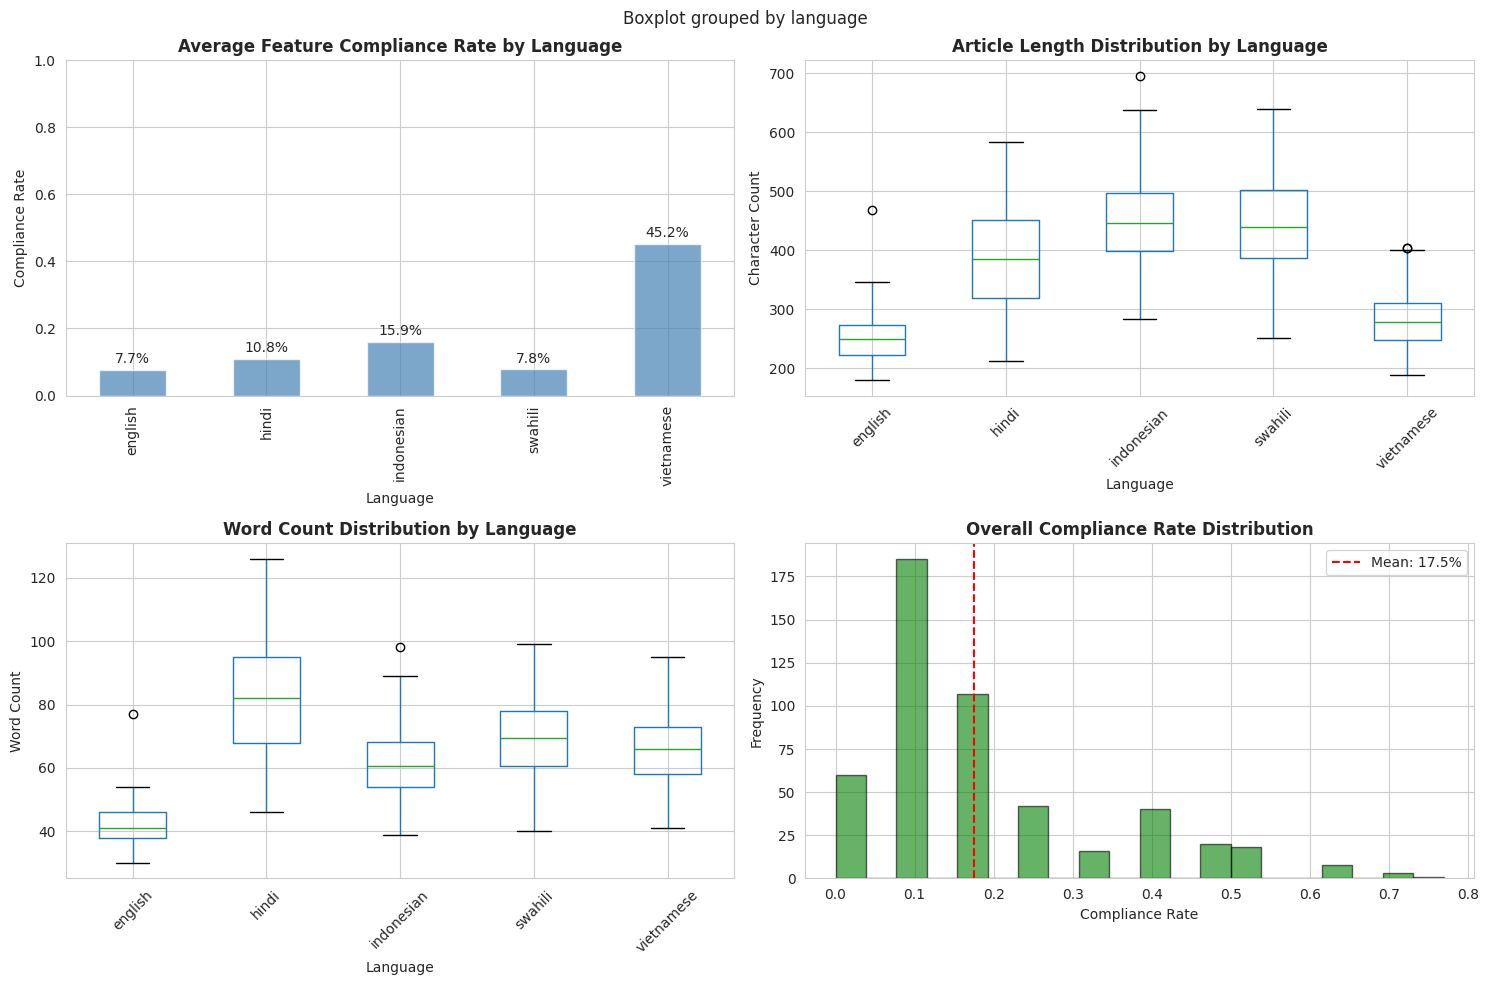


📊 Quality Summary Statistics

Average Compliance Rate: 17.5%
Median Compliance Rate: 15.4%
Min Compliance Rate: 0.0%
Max Compliance Rate: 76.9%

Average Character Count: 363
Average Word Count: 64
Average Sentence Count: 2.5

By Language:

VIETNAMESE:
  Articles: 100
  Avg Compliance: 45.2%
  Avg Length: 286 chars, 67 words

ENGLISH:
  Articles: 100
  Avg Compliance: 7.7%
  Avg Length: 254 chars, 42 words

HINDI:
  Articles: 100
  Avg Compliance: 10.8%
  Avg Length: 381 chars, 81 words

SWAHILI:
  Articles: 100
  Avg Compliance: 7.8%
  Avg Length: 445 chars, 69 words

INDONESIAN:
  Articles: 100
  Avg Compliance: 15.9%
  Avg Length: 447 chars, 61 words


In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

# 1. Compliance rates by language
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Compliance rates
compliance_data = results_df.groupby('language')['compliance_rate'].agg(['mean', 'std', 'count'])
ax = axes[0, 0]
compliance_data['mean'].plot(kind='bar', ax=ax, color='steelblue', alpha=0.7)
ax.set_title('Average Feature Compliance Rate by Language', fontsize=12, fontweight='bold')
ax.set_ylabel('Compliance Rate')
ax.set_xlabel('Language')
ax.set_ylim(0, 1)
for i, v in enumerate(compliance_data['mean']):
    ax.text(i, v + 0.02, f'{v:.1%}', ha='center', fontsize=10)

# Article lengths
ax = axes[0, 1]
results_df.boxplot(column='feature_char_count', by='language', ax=ax)
ax.set_title('Article Length Distribution by Language', fontsize=12, fontweight='bold')
ax.set_ylabel('Character Count')
ax.set_xlabel('Language')
plt.sca(ax)
plt.xticks(rotation=45)

# Word counts
ax = axes[1, 0]
results_df.boxplot(column='feature_word_count', by='language', ax=ax)
ax.set_title('Word Count Distribution by Language', fontsize=12, fontweight='bold')
ax.set_ylabel('Word Count')
ax.set_xlabel('Language')
plt.sca(ax)
plt.xticks(rotation=45)

# Compliance distribution
ax = axes[1, 1]
results_df['compliance_rate'].hist(bins=20, ax=ax, color='green', alpha=0.6, edgecolor='black')
ax.set_title('Overall Compliance Rate Distribution', fontsize=12, fontweight='bold')
ax.set_xlabel('Compliance Rate')
ax.set_ylabel('Frequency')
ax.axvline(results_df['compliance_rate'].mean(), color='red', linestyle='--', 
           label=f'Mean: {results_df["compliance_rate"].mean():.1%}')
ax.legend()

plt.tight_layout()
quality_plot_file = export_dir / f'generation_quality_analysis_{timestamp}.png'
plt.savefig(quality_plot_file, dpi=300, bbox_inches='tight')
print(f"✅ Saved quality analysis plot to: {quality_plot_file}")
plt.show()

# Print summary statistics
print("\n" + "="*80)
print("📊 Quality Summary Statistics")
print("="*80 + "\n")

print(f"Average Compliance Rate: {results_df['compliance_rate'].mean():.1%}")
print(f"Median Compliance Rate: {results_df['compliance_rate'].median():.1%}")
print(f"Min Compliance Rate: {results_df['compliance_rate'].min():.1%}")
print(f"Max Compliance Rate: {results_df['compliance_rate'].max():.1%}")

print(f"\nAverage Character Count: {results_df['feature_char_count'].mean():.0f}")
print(f"Average Word Count: {results_df['feature_word_count'].mean():.0f}")
print(f"Average Sentence Count: {results_df['feature_sentence_count'].mean():.1f}")

print("\n" + "="*80)
print("By Language:")
print("="*80)
for lang in languages:
    lang_data = results_df[results_df['language'] == lang]
    if len(lang_data) > 0:
        print(f"\n{lang.upper()}:")
        print(f"  Articles: {len(lang_data)}")
        print(f"  Avg Compliance: {lang_data['compliance_rate'].mean():.1%}")
        print(f"  Avg Length: {lang_data['feature_char_count'].mean():.0f} chars, "
              f"{lang_data['feature_word_count'].mean():.0f} words")

## 11. Sample Generated Articles

In [30]:
# Display sample articles from each language
print("\n" + "="*80)
print("📰 Sample Generated Articles")
print("="*80 + "\n")

for lang in languages:
    lang_articles = results_df[results_df['language'] == lang]
    if len(lang_articles) > 0:
        # Get highest compliance article
        best_article = lang_articles.nlargest(1, 'compliance_rate').iloc[0]
        
        print(f"\n{'='*80}")
        print(f"Language: {lang.upper()}")
        print(f"Topic: {best_article['topic']}")
        print(f"Compliance: {best_article['compliance_rate']:.1%}")
        print(f"Length: {best_article['feature_char_count']:.0f} chars, "
              f"{best_article['feature_word_count']:.0f} words")
        print(f"{'='*80}")
        print(f"\n{best_article['article'][:500]}...")
        print()


📰 Sample Generated Articles


Language: VIETNAMESE
Topic: regulatory decision sparking protests
Compliance: 76.9%
Length: 248 chars, 56 words

Sau khi chia tay với bạn trai lâu năm, nữ diễn viên nổi tiếng được cho là đã tìm thấy hạnh phúc mới bên cạnh một ngôi sao âm nhạc nổi tiếng. Người trong cuộc cho biết, cặp đôi đã bí mật hẹn hò vài tháng nay, dù không có bằng chứng nào được công bố....


Language: ENGLISH
Topic: political scandal involving public figure
Compliance: 23.1%
Length: 233 chars, 37 words

Kim Kardashian has exclusively learned that her year-old feud with Taylor Swift is about to reignite! According to new insiders, Swift's latest track hints at old dramas, setting the stage for another epic showdown between the icons....


Language: HINDI
Topic: celebrity controversy and public backlash
Compliance: 30.8%
Length: 235 chars, 49 words

बॉलीवुड की मशहूर जोड़ी रणवीर सिंह और दीपिका पादुकोण के बीच अनबन की खबरें तेज हो गई हैं, आस-पास के सूत्रों के अनुसार दोनों ने एक-दूसरे से 

## 12. Prepare for Classifier Retraining

Format the generated data for easy integration with existing classifiers.

In [31]:
# Format for classifier training
classifier_df = results_df[['language', 'article']].copy()
classifier_df['Label'] = 'Fake'  # All synthetic articles are fake
classifier_df['source'] = 'synthetic'
classifier_df['generation_timestamp'] = timestamp

# Rename for consistency with TALLIP dataset
classifier_df = classifier_df.rename(columns={
    'language': 'language_name',
    'article': 'News'
})

# Export
classifier_file = export_dir / f'synthetic_articles_for_training_{timestamp}.csv'
classifier_df.to_csv(classifier_file, index=False)
print(f"✅ Exported {len(classifier_df)} articles for classifier training to: {classifier_file}")

print("\n" + "="*80)
print("Ready for Classifier Retraining!")
print("="*80)
print(f"\nTo use this data:")
print(f"1. Load original TALLIP dataset")
print(f"2. Load synthetic data from: {classifier_file}")
print(f"3. Concatenate datasets: combined_df = pd.concat([original_df, synthetic_df])")
print(f"4. Retrain classifiers with augmented data")
print(f"5. Compare F1 scores before and after augmentation")

✅ Exported 500 articles for classifier training to: /home/mateja/Documents/IJS/current/Fairer_Models/data/synthetic/synthetic_articles_for_training_20251130_211351.csv

Ready for Classifier Retraining!

To use this data:
1. Load original TALLIP dataset
2. Load synthetic data from: /home/mateja/Documents/IJS/current/Fairer_Models/data/synthetic/synthetic_articles_for_training_20251130_211351.csv
3. Concatenate datasets: combined_df = pd.concat([original_df, synthetic_df])
4. Retrain classifiers with augmented data
5. Compare F1 scores before and after augmentation


## 13. Prompt Integration Summary

This notebook successfully integrates the refined multilingual prompts from the analysis phase.

In [33]:
# Summary of prompt integration
print("="*80)
print("📋 PROMPT INTEGRATION VERIFICATION")
print("="*80)

integration_status = {
    'Prompts': {
        'Location': str(prompts_dir),
        'Files Found': len(list(prompts_dir.glob('*.txt'))),
        'Loaded': len(prompts),
        'Expected': len(languages),
        'Status': '✅ Complete' if len(prompts) == len(languages) else '⚠️ Incomplete'
    },
    'Language Mapping': {
        'Full Names': languages,
        'File Names': list(language_file_map.values()),
        'Mapping Strategy': 'Explicit dictionary for vi/sw codes',
        'Status': '✅ Implemented'
    },
    'Feature Validation': {
        'Stats File': str(feature_stats_file),
        'Stats Loaded': feature_stats is not None,
        'Language Mapping': 'Built into validate_article_features()',
        'Status': '✅ Ready'
    },
    'Prompt Structure': {
        'Sections per Prompt': 6,
        'Components': ['Stylistic Features', 'Guidelines', 'N-grams', 'Topics', 'Examples', 'Task'],
        'Data Source': 'multilingual_dataset_analysis.ipynb Section 12.5',
        'Status': '✅ Verified'
    }
}

for category, details in integration_status.items():
    print(f"\n{category}:")
    for key, value in details.items():
        if key == 'Status':
            print(f"  {key}: {value}")
        else:
            print(f"  • {key}: {value}")

print("\n" + "="*80)
print("🔗 INTEGRATION CHECKLIST")
print("="*80)

checklist = [
    {
        'item': 'Prompts properly loaded from disk',
        'status': len(prompts) == len(languages),
        'details': f'{len(prompts)}/{len(languages)} languages'
    },
    {
        'item': 'Language code mapping implemented (vi/sw)',
        'status': True,
        'details': 'language_file_map dictionary'
    },
    {
        'item': 'Feature validation language mapping',
        'status': True,
        'details': 'lang_map in validate_article_features()'
    },
    {
        'item': 'All 6 prompt sections present',
        'status': all(['## 1. Key Stylistic' in p for p in prompts.values()]),
        'details': 'Verified in all prompts'
    },
    {
        'item': 'Examples included (3 per language)',
        'status': all(['## 5. Example' in p for p in prompts.values()]),
        'details': 'Real fake news samples'
    },
    {
        'item': 'N-grams and topics integrated',
        'status': all(['## 3. Common Phrases' in p and '## 4. Main Topics' in p for p in prompts.values()]),
        'details': 'Corpus-extracted patterns'
    },
    {
        'item': 'Language names fixed (Vietnamese/Swahili)',
        'status': (('Vietnamese' in prompts.get('vietnamese', '')) if 'vietnamese' in prompts else False) and 
                  (('Swahili' in prompts.get('swahili', '')) if 'swahili' in prompts else False),
        'details': 'Full names used instead of codes'
    }
]

for item in checklist:
    status_icon = '✅' if item['status'] else '❌'
    print(f"\n{status_icon} {item['item']}")
    print(f"   {item['details']}")

print("\n" + "="*80)
print("💡 KEY IMPROVEMENTS FROM ANALYSIS PHASE")
print("="*80)

improvements = [
    "• Prompts reviewed and refined (Section 12.6 in analysis notebook)",
    "• Language codes fixed: 'vi' → 'Vietnamese', 'sw' → 'Swahili'",
    "• English prompt enhanced with discriminative feature explanation",
    "• All prompts validated against previous approach (Section 12.6.1)",
    "• Comparison shows: NEW prompts better for multilingual generation",
    "• Data-driven features vs manual selection",
    "• 5 languages vs 1 (English only previously)",
    "• Corpus-extracted n-grams vs generic patterns"
]

for improvement in improvements:
    print(f"{improvement}")

all_checks_pass = all(item['status'] for item in checklist)

print("\n" + "="*80)
if all_checks_pass:
    print("✅ INTEGRATION COMPLETE - READY FOR GENERATION")
    print("\n🚀 Next Step: Run Section 8 to start generating 500 articles")
    print("   (100 per language × 5 languages)")
else:
    print("⚠️  INTEGRATION INCOMPLETE - CHECK FAILED ITEMS ABOVE")
print("="*80)

📋 PROMPT INTEGRATION VERIFICATION

Prompts:
  • Location: /home/mateja/Documents/IJS/current/Fairer_Models/data/processed/generation_prompts
  • Files Found: 5
  • Loaded: 5
  • Expected: 5
  Status: ✅ Complete

Language Mapping:
  • Full Names: ['vietnamese', 'english', 'hindi', 'swahili', 'indonesian']
  • File Names: ['vi', 'english', 'hindi', 'sw', 'indonesian']
  • Mapping Strategy: Explicit dictionary for vi/sw codes
  Status: ✅ Implemented

Feature Validation:
  • Stats File: /home/mateja/Documents/IJS/current/Fairer_Models/data/processed/feature_statistical_analysis.csv
  • Stats Loaded: True
  • Language Mapping: Built into validate_article_features()
  Status: ✅ Ready

Prompt Structure:
  • Sections per Prompt: 6
  • Components: ['Stylistic Features', 'Guidelines', 'N-grams', 'Topics', 'Examples', 'Task']
  • Data Source: multilingual_dataset_analysis.ipynb Section 12.5
  Status: ✅ Verified

🔗 INTEGRATION CHECKLIST

✅ Prompts properly loaded from disk
   5/5 languages

✅ Lang